# 1.Database

## 1.1

In [1]:
pixel = 92*112
print(pixel)

10304


There are 400 images in the database.
There are 10304 pixels in each image.

# 2.Presentation of the model

## 2.1

### 2.1.1 Show that the objective function is not convex

To prove it's not convex, we have an example.

We take $W1=[0]$, $W2=[1]$, $H1=[1]$, $H2=[0]$, $M=[0]$

So we calculate: $$L(W1, H1) = 0, L(W2, H2) = 0, L(\frac{W1+W2}{2}, \frac{H1+H2}{2}) = \frac{1}{32}$$

Because: $$\frac{1}{2} * (L(W1, H1) + L(W2, H2)) \lt L(\frac{W1+W2}{2}, \frac{H1+H2}{2})$$

So: it's not convex

### 2.1.2 Calculate its gradient.

We have: 

$L(W,H) = \frac{1}{2np}*{||M-WH||}_{F}^{2}$

$L(W+u,H+v) = L(W,H) + <\nabla_W{L(W,H)},u> + <\nabla_H{L(W,H)},v> + o(||(u,v)||)$

And we calculate: 

$L(W+u,H+v) = \frac{1}{2np} * <M-(W+u)(H+v), M-(W+u)(H+v)> $
$    = \frac{1}{2np}<M-WH-Wv-Hu, M-WH-Wv-Hu> + o(||(u,v)||)$
$    = \frac{1}{2np} <M-WH, M-WH> - \frac{1}{np} <M-WH, Wv+Hu> + o(||(u,v)||)$
$    = L(W,H) - \frac{1}{np} <(M-WH)H^T,u> - \frac{1}{np} <W^T(M-WH),v> + o(||(u,v)||)$
    
By comparing the equations above, we have: 

$$\nabla_W{L(W,H)} = -\frac{1}{np}(M-WH)H^T$$

$$\nabla_H{L(W,H)} = -\frac{1}{np}W^T(M-WH)$$


### 2.1.3 Is the gradient Lipschitz continuous?

The gradient is not Lipschitz continuous because the degree of these fonctions is larger than 1. 

# 3.Find W when H0 is fixed

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import  svds
from numpy.linalg import norm
from skimage import img_as_float
import scipy.optimize
import scipy.sparse

## 3.1

First, we use **W0, S, H0 = scipy.sparse.linalg.svds(M, k)** to factorize the matrix M.

In this choice, we use W0 = numpy.maximum(0, W0 * numpy.sqrt(S)) and H0 = numpy.maximum(0,(H0.T * numpy.sqrt(S)).T) to make sure the initial matrix W0 and H0 is positive, which is the goal of Nonnegative Matrix Factorization. 

With these, we can reduce the complexity of the calculation after and accelerate it.

For other posibilities, we can use random positive matrix.

## 3.2

Yes, the objective function g is convex.

Because: g is a combination of quadratic function and linear function, while quadratic function and linear function are both convex

So g is convex as well.

To calculate its gradient, by the question 2.1.2:

$\nabla{g(W)} = -\frac{1}{np}(M-WH)H_0^T$

## 3.3

In [3]:
def build_matrix_from_faces(folder='att_faces', minidata=False):
    # load images
    # 400 images of size (112, 92)
    M = []
    if minidata is True:
        nb_subjects = 1
    else:
        nb_subjects = 40
    for subject in range(1, nb_subjects + 1
                        ):
        for image in range(1, 11):
            face = plt.imread(folder + '/s' + str(subject)
                              + '/' + str(image) + '.pgm')
            M.append(face.ravel())

    return np.array(M, dtype=float)

def vectorize(W, H):
    return np.concatenate((W.ravel(), H.ravel()))

def unvectorize_M(W_H, M):
    # number of elements in W_H is (n+p)*k where M is of size n x m
    # W has the nk first elements
    # H has the kp last elements
    n, p = M.shape
    k = W_H.shape[0] // (n + p)
    W = W_H[:n * k].reshape((n, k))
    H = W_H[n * k:].reshape((k, p))
    return W, H

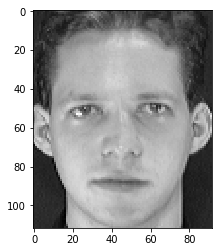

In [4]:
# Small data to test the algorithm
M = build_matrix_from_faces(folder='att_faces', minidata=True)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 2
# To see the first face:
plt.imshow(M[0].reshape((112, 92)), cmap='gray'); plt.show()

In [5]:
# Full data
M = build_matrix_from_faces(folder='att_faces', minidata=False)
def unvectorize(W_H): return unvectorize_M(W_H, M)
k = 38
n, p = M.shape
W, S, H = svds(M, k)
W = np.maximum(0, W * np.sqrt(S))
H = np.maximum(0,(H.T * np.sqrt(S)).T)

In [6]:
def val_g(W):
    return 1/(2*n*p)*(norm(M-np.dot(W, H0))**2)

def grad_g(W):
    return -1/(n*p)*np.dot((M-np.dot(W, H0)), H0.T)

In [7]:
## initilisation

W0 = W
H0 = H

In [8]:
val_g(W0)

867.6350229602598

In [9]:
grad_g(W0)

array([[0.0172934 , 0.01731904, 0.01540402, ..., 0.07276419, 0.03879833,
        0.25333461],
       [0.01554563, 0.02056321, 0.01834088, ..., 0.04449452, 0.05265991,
        0.41571801],
       [0.02560152, 0.02760649, 0.02700951, ..., 0.07270818, 0.0546179 ,
        0.41152049],
       ...,
       [0.0171698 , 0.01912146, 0.01781624, ..., 0.03338525, 0.04315752,
        0.32001701],
       [0.01758595, 0.0235722 , 0.020001  , ..., 0.03991636, 0.05232479,
        0.33582498],
       [0.01795233, 0.01865527, 0.01813591, ..., 0.03375649, 0.04871939,
        0.33763142]])

In [10]:
## check computations with **scipy.optimize.check grad**
def g_t(W):
    W = np.reshape(W, (-1, k))
    return 1/(2*n*p)*(norm(M-np.dot(W, H0))**2)
def grad_g_t(W):
    W = np.reshape(W, (-1, k))
    return -1/(n*p)*np.dot((M-np.dot(W, H0)), H0.T).reshape(-1)

scipy.optimize.check_grad(g_t, grad_g_t, np.reshape(W0, -1))

0.001742833843045114

## 3.4

We have :

$${\operatorname{prox}}_{\gamma_{\iota_{\mathbb{R}_+}}} (x_k) = \underset{y \in \mathbb{R}^n}{\operatorname{argmin}} \iota_{\mathbb{R}_+}(y) + \frac{1}{2\gamma} {||y-x_k||}^2) $$

We know that for y negative, $\iota_{\mathbb{R}_+}(y)$ is always inifinie. So minimize
$\iota_{\mathbb{R}_+}(y) + \frac{1}{2\gamma} {||y-x_k||}^2 $ , we want y positive to let $\iota_{\mathbb{R}_+}(y) = 0$


For $x_k$ negative, to minimize the objective function, $y = 0$

For $x_k$ positive, to minimize the objective function, $y = x_k$

so it's the projection onto $\mathbb{R}_+$.

In [11]:
def l(x):
    if(x<0): 
        return inf
    else: 
        return 0    
L0 = norm(np.dot(H0.T, H0))/(n*p)

## 3.5

In [12]:
def projected_gradient_method(val_g, grad_g, W0, gamma, N):
    for i in range(N):
        W0 = W0-gamma*grad_g(W0)
        W0 =  np.maximum(W0, 0) 
#         print(val_g(W0))
    return val_g(W0)   

## 3.6

In [13]:
W0 = W
H0 = H
projected_gradient_method(val_g, grad_g, W0, 1/L0, 100)

491.00633149927086

In [14]:
1/L0

14.242365918229154

## 4.1

In [15]:
## we implement Armijo's line search

def find_l(val_g, grad_g, x0, beta, a, b):
    l = 0;
    x_k = x0;
    x_plus = x_k - grad_g(x_k)*b*a**l;
    while (val_g(x_plus) > val_g(x_k)+beta*np.vdot(grad_g(x_k), x_plus-x_k)):
        l += 1;
        x_plus = x_k - grad_g(x_k)*b*a**l
#         print(l);
    return l;

def line_search(val_g, grad_g, x0, a, b, beta, N):
    x_k = x0;
    for i in range(N):
        l = find_l(val_g, grad_g, x_k, beta, a, b);
        x_k = x_k - b*a**l*grad_g(x_k);
        x_k = np.maximum(x_k, 0)
#         print(l);
#         print(str(i) + " :", val_g(x_k))
    return val_g(x_k)


In [16]:
line_search(val_g, grad_g, W0, 0.5, 20, 0.5, 100)

487.749856944986

## 4.2

In [17]:
import time
print('projected gradient method:')
start = time.time()
res = projected_gradient_method(val_g, grad_g, W0, 1/L0, 100)
print('time cost:', time.time()-start)
print('result:', res)
print('\nline search method:')
start = time.time()
res = line_search(val_g, grad_g, W0, 0.5, 20, 0.5, 100)
print('time cost:', time.time()-start)
print('result:', res)

projected gradient method:
time cost: 3.2217111587524414
result: 491.00633149927086

line search method:
time cost: 14.84333610534668
result: 487.749856944986


We can see that the results of two algorithms are nearly the same while the time of the projected gradient method is less than that of line search method. 

## 5.1

In [18]:
line_search(val_g, grad_g, W0, 0.5, 20, 0.5, 1000)

483.0540348132402

## 5.2

The objective function is:
$$f(W, H)= \frac{1}{2np}\lVert M-WH \rVert^2_F$$
From the question 3.1, we know that
$$g(W0)= \frac{1}{2np}\lVert M-W0H0 \rVert^2_F \geq \frac{1}{2np}\lVert M-W1H0 \rVert^2_F = g(W1)$$
So in this method, in each iteration, we have:
$$f(W_t, H_{t-1}) \leq f(W_{t-1}, H_{t-1})$$
For the same reason, in each iteration, we have:
$$f(W_t, H_t) \leq f(W_t, H_{t-1})$$
Consequently:
$$f(W_t, H_t) \leq f(W_t, H_{t-1}) \leq f(W_{t-1}, H_{t-1})$$

Therefore, the value of the objective in decreasing at each iteration.

In addition, the objective function with a normalization Frobenuis is always positive, so the objective function is not going to decrease infinitely, and the value converges.

## 5.3

In [19]:
def val_g(W, H, isWFirst = True):
    if isWFirst: return 1/(2*n*p)*(norm(M-np.dot(W, H))**2)
    else: return 1/(2*n*p)*(norm(M-np.dot(H, W))**2)

def grad_g_H(H, W):
    return -1/(n*p)*np.dot(W.T, (M-np.dot(W, H)))

def grad_g_W(W, H):
    return -1/(n*p)*np.dot((M-np.dot(W, H)), H.T)

def find_l(val_g, grad_g, x0, y0, beta, a, b, isWFirst = True):
    l = 0;
    x_k = x0;
    x_plus = x_k - grad_g(x_k, y0)*b*a**l;
    while (val_g(x_plus, y0, isWFirst) > val_g(x_k, y0, isWFirst)+beta*np.vdot(grad_g(x_k, y0), x_plus-x_k)):
        l += 1;
        x_plus = x_k - grad_g(x_k, y0)*b*a**l
#         print(l);
    return l;

def line_search_full(val_g, grad_g_H, grad_g_W, H0, W0, a, b, beta, N):
    H_k = H0;
    W_k = W0;
    ls = [];
    ls.append(val_g(W_k, H_k));
    for i in range(N):
        l = find_l(val_g, grad_g_W, W_k, H_k, beta, a, b);
        W_k = W_k - b*a**l*grad_g_W(W_k, H_k);
        W_k = np.maximum(W_k, 0)
        l = find_l(val_g, grad_g_H, H_k, W_k, beta, a, b, False);
        H_k = H_k - b*a**l*grad_g_H(H_k, W_k);
        H_k = np.maximum(H_k, 0)
        ls.append(val_g(W_k, H_k));
#         print(l);
#         print(str(i) + " :", val_g(W_k, H_k))
    return (W_k, H_k, ls)


In [20]:
print('projected gradient method:')
start = time.time()
(W_k, H_k, l) = line_search_full(val_g, grad_g_H, grad_g_W, H0, W0, a=0.5, b=10, beta=0.5, N=1000)
print('time cost:', time.time()-start)
print('result:', val_g(W_k, H_k))

projected gradient method:
time cost: 378.5557701587677
result: 200.0859895644826


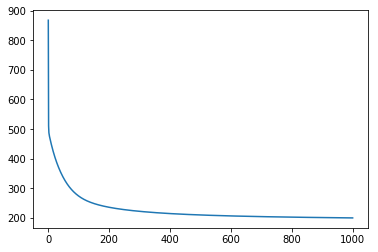

In [21]:
plt.plot(l)

projected gradient method:
time cost: 35.089239835739136
result: 273.76855860773384


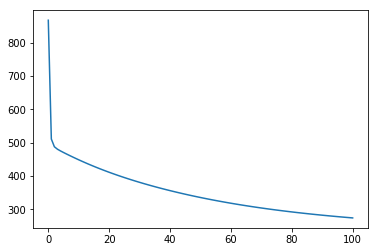

In [22]:
print('projected gradient method:')
start = time.time()
(W_k, H_k, l) = line_search_full(val_g, grad_g_H, grad_g_W, H0, W0, a=0.5, b=10, beta=0.5, N=100)
print('time cost:', time.time()-start)
print('result:', val_g(W_k, H_k))
plt.plot(l)

## 5.4

Comparing projected gradient (PG) and alternate minimizations (AM) methods:

- Solution is not the same: AM is better than PG
- Objective value is not the same: AM (273.76) is better than PG (491.00)
- Time: PG (5.07) is shorter than AM (39.68)

Conclusion: the converge speed of AM is much faster than PG while it takes less time to computer the same number of iteration by PG than by AM. 

## 5.5

Instead of just using the number of iterations, maybe we can caluculate the decrease of objective values between each iteration. 

We can set a very small value epsilon and stop the algorithm when $$||f(W_{t}, H_{t})  - f(W_{t-1}, H_{t-1})||  \lt epsilon$$